# ОБУЧЕНИЕ POINTNET СЕТЕЙ ПО КЛАССИФИКАЦИИ НА ОСНОВЕ ОБЛАКОВ ТОЧЕК ВЭКГ

In [1]:
import os
import numpy as np
import itertools
import math, random
from glob import glob

from func import *
from model import *

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd

import scipy.spatial.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Установка Seed для воспроизводимости
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Демонстрация нормализации (StandardScaler) исходных облаков точек:

In [2]:
file_path = 'final_pointcloud_dataset/train/00002_period_3.csv'
file_path_normalized = 'final_pointcloud_dataset_normalized/train/00002_period_3_normalized.csv'

print('Исходное облако точек:')
# Чтение CSV-файла
df = pd.read_csv(file_path)
point_cloud_array = df[['x', 'y', 'z']].values
pcshow(*point_cloud_array.T)


print('Нормализованное облако точек:')
# Чтение CSV-файла
df_normalized = pd.read_csv(file_path_normalized)
point_cloud_array = df_normalized[['x', 'y', 'z']].values
pcshow(*point_cloud_array.T)

Исходное облако точек:


Нормализованное облако точек:


---

# Преподготовка данных перд обучением сетей:

Кастомные траснсформации датасета:

In [3]:
# Реализация нормального шума
class RandomNoise(object):
    def __init__(self, std=0.002):
        self.std = std
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, self.std, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud


class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

# Реализация нормализации чтобы максильное значение равнялось 1 (схоже с методом в изображениях)
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud


# Создание рандомного семплирования (если точек меньше то просто добавлю дубликаты чтобы добить число)
class PointSampler:
    def __init__(self, num_points=512): 
        self.num_points = num_points

    def __call__(self, pointcloud):
        num_total_points = pointcloud.shape[0]
        
        if num_total_points < self.num_points:
              
            # Семплирование оставшихся точек из уже существующих точек
            sampled_indices = np.random.choice(num_total_points, self.num_points - num_total_points, replace=True)
            duplicated_points = pointcloud[sampled_indices, :]
            
            # Собираем все точки в итоговую выборку
            sampled_points = np.vstack((pointcloud, duplicated_points))
            #print("Всего точек меньше чем надо семплировать - будут дубликаты")
        else:
            # Случайно берем точки:
            sampled_indices = np.random.choice(num_total_points, self.num_points, replace=False)
            sampled_points = pointcloud[sampled_indices, :]
        
        return sampled_points

# Создание рандомного семплирования  с попыткой брать больше точек что дальше лежат от (0,0) 
# (если точек меньше то просто добавлю дубликаты чтобы добить число)
class PointSampler_weighted:
    def __init__(self, num_points=512): 
        self.num_points = num_points

    def __call__(self, pointcloud):
        num_total_points = pointcloud.shape[0]
        
        if num_total_points < self.num_points:
              
            # Семплирование оставшихся точек из уже существующих точек
            sampled_indices = np.random.choice(num_total_points, self.num_points - num_total_points, replace=True)
            duplicated_points = pointcloud[sampled_indices, :]
            
            # Собираем все точки в итоговую выборку
            sampled_points = np.vstack((pointcloud, duplicated_points))
            #print("Всего точек меньше чем надо семплировать - будут дубликаты")
        else:
            # Выше вероятность чем дальше от 0,0
            distances = np.linalg.norm(pointcloud, axis=1)
            weights = distances / np.sum(distances)

            sampled_indices = np.random.choice(num_total_points, self.num_points, replace=False, p=weights)
            sampled_points = pointcloud[sampled_indices, :]
        
        return sampled_points

__Пример нормализации с приведением максильного значения к 1:__

In [4]:
point_cloud_array = df[['x', 'y', 'z']].values
norm_pointcloud = Normalize()(point_cloud_array)
pcshow(*norm_pointcloud.T)

__Пример добавления небольшого шума:__

In [5]:
sampled_point_cloud = RandomNoise(std=0.01)(norm_pointcloud)
pcshow(*sampled_point_cloud.T)

__Семплирование точек:__ <br>
Пример с семплированием без весов:

In [6]:
sampled_point_cloud = PointSampler(150)(norm_pointcloud)
pcshow(*sampled_point_cloud.T)

Пример с семплированием c весами (делает шанс выбора точек более удаленных от начала координат более высоким):

In [7]:
sampled_point_cloud = PointSampler_weighted(150)(norm_pointcloud)
pcshow(*sampled_point_cloud.T)

In [8]:
# Класс Датасета
class PointCloudData(Dataset):
    def __init__(self, root, subset_type, transform=None):

        self.df_gt = pd.read_csv(f"{root}/{subset_type}/ground_truth.csv", index_col=0)

        self.df_gt['class'] = self.df_gt['EF'].apply(lambda x: 1 if x < 50 else 0)

        self.csv_paths = glob(f"{root}/{subset_type}/*.csv")
        self.csv_paths = [path for path in self.csv_paths if path != f"{root}/{subset_type}\\ground_truth.csv"]
        self.transform = transform
        self.classes = {0 : 'normal', 1 : 'pathology'}

    def __len__(self):
        return len(self.csv_paths)

    def __getitem__(self, idx):
        file_path = self.csv_paths[idx]
        df = pd.read_csv(file_path)
        point_cloud = df[['x', 'y', 'z']].values

        if self.transform:
            pointcloud = self.transform(point_cloud)

        target = self.df_gt.loc[os.path.basename(file_path)]['class'] 

        return  {'pointcloud': pointcloud, 
                'category': target}

In [9]:
# КОНСТАНТЫ:
BATCH_SIZE = 64

# Путь к корневой папке датасета
DATASET_PATH = "final_pointcloud_dataset"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [10]:
train_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    RandomNoise(std=0.001),
                    ToTensor()
                    ])

val_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    ToTensor()
                    ])

train_ds = PointCloudData(DATASET_PATH, "train", transform=train_transforms)
valid_ds = PointCloudData(DATASET_PATH, "val", transform=val_transforms)

train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE)

In [11]:
classes = {'normal' : 0, 'pathology': 1}
inv_classes = {0 : 'normal', 1 : 'pathology'}
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))

print('\nПример первого элемент тренировочного датасета:')
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])
pcshow(*train_ds[0]['pointcloud'].T)

Train dataset size:  1757
Valid dataset size:  578
Number of classes:  2

Пример первого элемент тренировочного датасета:
Sample pointcloud shape:  torch.Size([512, 3])
Class:  normal


# ОБУЧЕНИЕ НЕЙРОСЕТИ:

### Как запустить сервер MLflow:
```
mlflow server --backend-store-uri "file:///C:/ML_flow_server" --host localhost --port 5000
```
По этой ссылке будет доступен MLflow: http://localhost:5000

In [12]:
# Инициализация MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("VECG_POINTNET_Classification")

<Experiment: artifact_location='mlflow-artifacts:/938020304188881611', creation_time=1693415462481, experiment_id='938020304188881611', last_update_time=1693415462481, lifecycle_stage='active', name='VECG_POINTNET_Classification', tags={}>

In [13]:
# Определение количества итераций в одной эпохе
iterations_per_epoch = len(train_loader)
print('Число градиентных спусков за 1 эпоху раняется', iterations_per_epoch)

Число градиентных спусков за 1 эпоху раняется 27


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pointnet = PointNet()
pointnet.to(device)

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

В PointNet классификаторе используется комбинированная функция потерь:

NLLLoss (Negative Log Likelihood Loss): Это стандартная функция потерь для задач классификации с несколькими классами. Она вычисляет отрицательный логарифм вероятности правильного класса для каждого образца и усредняет результаты по всем образцам в пакете.

Loss_reg (Дополнительная регуляризационная потеря): Эта часть функции потерь представляет собой норму разности между идентичной матрицей и произведением аффинных трансформаций. Она используется для принудительного ортогонализации и/или единичности матриц трансформации. Это помогает сохранить структурные свойства данных в процессе обучения.

Сумма этих двух компонентов образует итоговую функцию потерь

---

In [15]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='train small lr', lr=0.00025, epochs=30,
                     scheduler=True, scheduler_step_size=10, dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', gamma=0.5, noise_std=0.001)

Epoch 1/30, Train Loss: 1.3506, Train Aсс: 0.7321 Val Loss: 1.3071, Val Acc:0.6955 
Epoch 5/30, Train Loss: 0.1703, Train Aсс: 0.9606 Val Loss: 0.7707, Val Acc:0.7907 
Epoch 10/30, Train Loss: 0.0589, Train Aсс: 0.9867 Val Loss: 0.6494, Val Acc:0.8374 
Epoch 15/30, Train Loss: 0.0175, Train Aсс: 0.9983 Val Loss: 0.7185, Val Acc:0.8097 
Epoch 20/30, Train Loss: 0.0190, Train Aсс: 0.9959 Val Loss: 0.6636, Val Acc:0.8374 
Epoch 25/30, Train Loss: 0.0143, Train Aсс: 0.9983 Val Loss: 0.7098, Val Acc:0.8097 
Epoch 30/30, Train Loss: 0.0095, Train Aсс: 0.9994 Val Loss: 0.6129, Val Acc:0.8304 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.8645192468658814
Accuracy данной модели равно 0.8667820069204152


In [16]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='train big lr', lr=0.001, epochs=30,
                     scheduler=True, scheduler_step_size=10, dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', gamma=0.5, noise_std=0.001)

Epoch 1/30, Train Loss: 0.8725, Train Aсс: 0.7824 Val Loss: 1.0608, Val Acc:0.6955 
Epoch 5/30, Train Loss: 0.1493, Train Aсс: 0.9473 Val Loss: 0.5283, Val Acc:0.7422 
Epoch 10/30, Train Loss: 0.0703, Train Aсс: 0.9815 Val Loss: 0.4551, Val Acc:0.8235 
Epoch 15/30, Train Loss: 0.0402, Train Aсс: 0.9850 Val Loss: 0.4997, Val Acc:0.8581 
Epoch 20/30, Train Loss: 0.0292, Train Aсс: 0.9907 Val Loss: 0.4431, Val Acc:0.8685 
Epoch 25/30, Train Loss: 0.0049, Train Aсс: 1.0000 Val Loss: 0.4867, Val Acc:0.8633 
Epoch 30/30, Train Loss: 0.0083, Train Aсс: 0.9988 Val Loss: 0.6351, Val Acc:0.8426 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.872650501528629
Accuracy данной модели равно 0.8771626297577855


In [17]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='train big lr fast sheduler', lr=0.001, epochs=30,
                     scheduler=True, scheduler_step_size=5, dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', gamma=0.5, noise_std=0.001)

Epoch 1/30, Train Loss: 0.8725, Train Aсс: 0.7824 Val Loss: 1.0608, Val Acc:0.6955 
Epoch 5/30, Train Loss: 0.1493, Train Aсс: 0.9473 Val Loss: 0.5283, Val Acc:0.7422 
Epoch 10/30, Train Loss: 0.0523, Train Aсс: 0.9832 Val Loss: 0.4672, Val Acc:0.8304 
Epoch 15/30, Train Loss: 0.0179, Train Aсс: 0.9971 Val Loss: 0.4706, Val Acc:0.8616 
Epoch 20/30, Train Loss: 0.0079, Train Aсс: 0.9994 Val Loss: 0.4936, Val Acc:0.8547 
Epoch 25/30, Train Loss: 0.0059, Train Aсс: 1.0000 Val Loss: 0.4753, Val Acc:0.8737 
Epoch 30/30, Train Loss: 0.0047, Train Aсс: 1.0000 Val Loss: 0.5119, Val Acc:0.8495 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.872650501528629
Accuracy данной модели равно 0.8771626297577855


In [18]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='train small lr no sheduler', lr=0.00025, epochs=30,
                     scheduler=False,  dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', noise_std=0.001)

Epoch 1/30, Train Loss: 1.3506, Train Aсс: 0.7321 Val Loss: 1.3071, Val Acc:0.6955 
Epoch 5/30, Train Loss: 0.1703, Train Aсс: 0.9606 Val Loss: 0.7707, Val Acc:0.7907 
Epoch 10/30, Train Loss: 0.0589, Train Aсс: 0.9867 Val Loss: 0.6494, Val Acc:0.8374 
Epoch 15/30, Train Loss: 0.0569, Train Aсс: 0.9821 Val Loss: 0.5393, Val Acc:0.8391 
Epoch 20/30, Train Loss: 0.0138, Train Aсс: 0.9983 Val Loss: 0.5531, Val Acc:0.8512 
Epoch 25/30, Train Loss: 0.0226, Train Aсс: 0.9954 Val Loss: 0.6032, Val Acc:0.8270 
Epoch 30/30, Train Loss: 0.0057, Train Aсс: 1.0000 Val Loss: 0.5460, Val Acc:0.8391 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.87777450260689
Accuracy данной модели равно 0.8754325259515571


__Более высокий рандомный шум на трейновых данных:__

In [19]:
train_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    RandomNoise(std=0.005),
                    ToTensor()
                    ])

val_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    ToTensor()
                    ])
                    
DATASET_PATH = "final_pointcloud_dataset"
train_ds = PointCloudData(DATASET_PATH, "train", transform=train_transforms)
valid_ds = PointCloudData(DATASET_PATH, "val", transform=val_transforms)

train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE)

pcshow(*train_ds[0]['pointcloud'].T)

In [20]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='train big lr noisy', lr=0.001, epochs=30,
                     scheduler=True, scheduler_step_size=10, dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', gamma=0.5, noise_std=0.005)

Epoch 1/30, Train Loss: 0.9010, Train Aсс: 0.7697 Val Loss: 1.1051, Val Acc:0.6955 
Epoch 5/30, Train Loss: 0.1313, Train Aсс: 0.9549 Val Loss: 0.4076, Val Acc:0.8339 
Epoch 10/30, Train Loss: 0.0691, Train Aсс: 0.9821 Val Loss: 0.4058, Val Acc:0.8322 
Epoch 15/30, Train Loss: 0.0174, Train Aсс: 0.9959 Val Loss: 0.5605, Val Acc:0.8547 
Epoch 20/30, Train Loss: 0.0167, Train Aсс: 0.9959 Val Loss: 0.5586, Val Acc:0.8356 
Epoch 25/30, Train Loss: 0.0092, Train Aсс: 0.9977 Val Loss: 0.4564, Val Acc:0.8633 
Epoch 30/30, Train Loss: 0.0136, Train Aсс: 0.9977 Val Loss: 0.7075, Val Acc:0.8253 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.8682932647200675
Accuracy данной модели равно 0.870242214532872


In [21]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='train big lr fast sheduler noisy', lr=0.001, epochs=30,
                     scheduler=True, scheduler_step_size=5, dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', gamma=0.5, noise_std=0.005)

Epoch 1/30, Train Loss: 0.9010, Train Aсс: 0.7697 Val Loss: 1.1051, Val Acc:0.6955 
Epoch 5/30, Train Loss: 0.1313, Train Aсс: 0.9549 Val Loss: 0.4076, Val Acc:0.8339 
Epoch 10/30, Train Loss: 0.0530, Train Aсс: 0.9867 Val Loss: 0.5956, Val Acc:0.8287 
Epoch 15/30, Train Loss: 0.0192, Train Aсс: 0.9959 Val Loss: 0.5102, Val Acc:0.8547 
Epoch 20/30, Train Loss: 0.0149, Train Aсс: 0.9977 Val Loss: 0.5347, Val Acc:0.8391 
Epoch 25/30, Train Loss: 0.0106, Train Aсс: 0.9971 Val Loss: 0.5357, Val Acc:0.8460 
Epoch 30/30, Train Loss: 0.0048, Train Aсс: 1.0000 Val Loss: 0.4835, Val Acc:0.8512 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.8615316314637621
Accuracy данной модели равно 0.8633217993079585


In [22]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='train small lr no sheduler noisy', lr=0.00025, epochs=30,
                     scheduler=False,  dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', noise_std=0.001)

Epoch 1/30, Train Loss: 1.4061, Train Aсс: 0.7153 Val Loss: 1.2852, Val Acc:0.6955 
Epoch 5/30, Train Loss: 0.1314, Train Aсс: 0.9728 Val Loss: 0.5724, Val Acc:0.8426 
Epoch 10/30, Train Loss: 0.0532, Train Aсс: 0.9873 Val Loss: 0.5924, Val Acc:0.8356 
Epoch 15/30, Train Loss: 0.0454, Train Aсс: 0.9867 Val Loss: 0.7662, Val Acc:0.8235 
Epoch 20/30, Train Loss: 0.0321, Train Aсс: 0.9913 Val Loss: 0.5478, Val Acc:0.8374 
Epoch 25/30, Train Loss: 0.0385, Train Aсс: 0.9890 Val Loss: 0.5728, Val Acc:0.8131 
Epoch 30/30, Train Loss: 0.0300, Train Aсс: 0.9919 Val Loss: 0.4738, Val Acc:0.8651 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.8714866919862723
Accuracy данной модели равно 0.870242214532872


__Без аддитивного шума на трейновых данных:__

In [30]:
train_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    ToTensor()
                    ])
                    
val_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    ToTensor()
                    ])

DATASET_PATH = "final_pointcloud_dataset"
train_ds = PointCloudData(DATASET_PATH, "train", transform=train_transforms)
valid_ds = PointCloudData(DATASET_PATH, "val", transform=val_transforms)

train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE)

In [31]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='train small lr no sheduler without noise', lr=0.00025, epochs=30,
                     scheduler=False,  dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', noise_std=0)

Epoch 1/30, Train Loss: 1.3411, Train Aсс: 0.7280 Val Loss: 1.3343, Val Acc:0.6955 
Epoch 5/30, Train Loss: 0.1361, Train Aсс: 0.9653 Val Loss: 0.6658, Val Acc:0.8426 
Epoch 10/30, Train Loss: 0.0704, Train Aсс: 0.9803 Val Loss: 0.4763, Val Acc:0.8564 
Epoch 15/30, Train Loss: 0.0356, Train Aсс: 0.9919 Val Loss: 0.4719, Val Acc:0.8772 
Epoch 20/30, Train Loss: 0.0506, Train Aсс: 0.9873 Val Loss: 0.5683, Val Acc:0.8460 
Epoch 25/30, Train Loss: 0.0246, Train Aсс: 0.9942 Val Loss: 0.5446, Val Acc:0.8322 
Epoch 30/30, Train Loss: 0.0073, Train Aсс: 0.9994 Val Loss: 0.5212, Val Acc:0.8754 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.8785052746289072
Accuracy данной модели равно 0.8771626297577855


__Нормализация данных с помощью StandartScaller -> (values-mean)/std:__

In [26]:
train_transforms = transforms.Compose([
                    PointSampler(512),
                    ToTensor()
                    ])

val_transforms = transforms.Compose([
                    PointSampler(512),
                    ToTensor()
                    ])

DATASET_PATH = "final_pointcloud_dataset_normalized"
train_ds = PointCloudData(DATASET_PATH, "train", transform=train_transforms)
valid_ds = PointCloudData(DATASET_PATH, "val", transform=val_transforms)

train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE)
pcshow(*train_ds[0]['pointcloud'].T)

In [28]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='StandartScaller train small lr no sheduler without noise', lr=0.00025, epochs=30,
                     scheduler=False,  dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and std scaling', noise_std=0)

Epoch 1/30, Train Loss: 1.2467, Train Aсс: 0.7801 Val Loss: 1.2722, Val Acc:0.7439 
Epoch 5/30, Train Loss: 0.1575, Train Aсс: 0.9659 Val Loss: 0.7659, Val Acc:0.8397 
Epoch 10/30, Train Loss: 0.0650, Train Aсс: 0.9844 Val Loss: 0.6355, Val Acc:0.8606 
Epoch 15/30, Train Loss: 0.0706, Train Aсс: 0.9797 Val Loss: 0.5499, Val Acc:0.8537 
Epoch 20/30, Train Loss: 0.0134, Train Aсс: 0.9983 Val Loss: 0.7693, Val Acc:0.8188 
Epoch 25/30, Train Loss: 0.0079, Train Aсс: 1.0000 Val Loss: 0.8330, Val Acc:0.7909 
Epoch 30/30, Train Loss: 0.0050, Train Aсс: 1.0000 Val Loss: 0.9010, Val Acc:0.7979 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.8584000804354042
Accuracy данной модели равно 0.8606271777003485


In [29]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='StandartScaller train big lr without noise', lr=0.001, epochs=30,
                     scheduler=True, scheduler_step_size=10, dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and std scaling', gamma=0.5, noise_std=0)

Epoch 1/30, Train Loss: 0.7740, Train Aсс: 0.8258 Val Loss: 0.7838, Val Acc:0.7962 
Epoch 5/30, Train Loss: 0.1933, Train Aсс: 0.9352 Val Loss: 0.8108, Val Acc:0.8432 
Epoch 10/30, Train Loss: 0.1062, Train Aсс: 0.9635 Val Loss: 1.4389, Val Acc:0.7143 
Epoch 15/30, Train Loss: 0.0730, Train Aсс: 0.9751 Val Loss: 0.5590, Val Acc:0.8432 
Epoch 20/30, Train Loss: 0.0415, Train Aсс: 0.9878 Val Loss: 0.8310, Val Acc:0.7979 
Epoch 25/30, Train Loss: 0.0118, Train Aсс: 0.9983 Val Loss: 0.7596, Val Acc:0.7909 
Epoch 30/30, Train Loss: 0.0082, Train Aсс: 0.9994 Val Loss: 0.8499, Val Acc:0.8084 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.866113369022816
Accuracy данной модели равно 0.8623693379790941


---

---

## Оценка качества лучшей модели на валидации:

In [32]:
pointnet = PointNet()
# Загрузка сохраненных весов модели
pointnet.load_state_dict(torch.load('models/pointnet.pth'))

pointnet.eval().to('cpu')
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

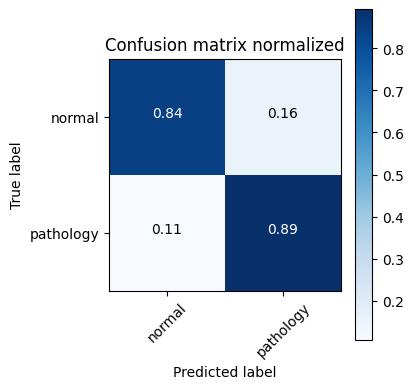

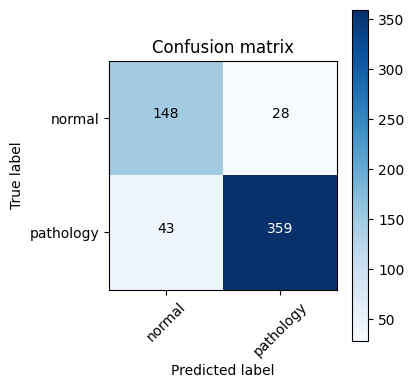

In [33]:
plt.figure(figsize=(4,4))
cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(cm, list(classes.keys()), normalize=True, title='Confusion matrix normalized')

plt.figure(figsize=(4,4))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)

In [34]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.77      0.84      0.81       176
           1       0.93      0.89      0.91       402

    accuracy                           0.88       578
   macro avg       0.85      0.87      0.86       578
weighted avg       0.88      0.88      0.88       578

